In [ ]:
# 1) Uninstall conflicting packages we don't use
!pip -q uninstall -y tensorflow cudf-cu12 cuml-cu12 dask-cuda umap-learn pynndescent stumpy shap librosa numba || true

# 2) Reinstall our clean stack (works on Python 3.12)
!pip -q install --upgrade pip
!pip -q install "numpy==2.2.6" "pandas==2.2.2" "scipy==1.14.1" "scikit-learn==1.5.2"
!pip -q install "torch==2.4.1" "torchvision==0.19.1" "torchaudio==2.4.1" -i https://download.pytorch.org/whl/cu121

In [ ]:
import numpy as np, pandas as pd, torch, sklearn, scipy
print("OK →",
      "numpy", np.__version__,
      "pandas", pd.__version__,
      "sklearn", sklearn.__version__,
      "scipy", scipy.__version__,
      "torch", torch.__version__)


OK → numpy 2.2.6 pandas 2.2.2 sklearn 1.5.2 scipy 1.14.1 torch 2.4.1+cu121


In [ ]:
CFG = {
    "task": "multitask",            # "pcos_only", "thyroid_only", or "multitask"
    "use_dummy_data": True,         # Set False and provide your CSVs
    "seq_len": 30,                  # target max length (will pad/truncate)
    "batch_size": 32,
    "epochs": 100,
    "patience": 10,                 # early stopping patience
    "lr": 1e-3,
    "dropout": 0.2,
    "hidden": 64,
    "num_layers": 1,
    "bi": False,                    # bidirectional RNN
    "use_class_weights": True,
    "use_wgan_gp": False,           # toggle GAN augmentation (optional cell later)
    "synthetic_ratio": 0.2,         # portion of synthetic per minibatch when GAN on
}
CFG

{'task': 'multitask',
 'use_dummy_data': True,
 'seq_len': 30,
 'batch_size': 32,
 'epochs': 100,
 'patience': 10,
 'lr': 0.001,
 'dropout': 0.2,
 'hidden': 64,
 'num_layers': 1,
 'bi': False,
 'use_class_weights': True,
 'use_wgan_gp': False,
 'synthetic_ratio': 0.2}

In [ ]:
from typing import List, Dict, Tuple

FEATURE_COLUMNS = [
    # <- Add your actual features here:
    "age","bmi","cycle_day","symptom_pain","symptom_acne","tsh","t3","t4"
]
CLASS_COL = "pcos_label"     # 0/1
REG_COL   = "tsh_next"       # float

def make_dummy_dataframe(n_patients=200, seq_len=30, pcos_rate=0.5):
    rows = []
    for pid in range(n_patients):
        label = 1 if np.random.rand() < pcos_rate else 0
        age = np.random.normal(27, 5)
        bmi = np.clip(np.random.normal(24 + 3*label, 4), 16, 40)
        tsh_base = np.random.normal(2.0 + 0.3*label, 0.6)
        t3_base  = np.random.normal(1.2, 0.2)
        t4_base  = np.random.normal(8.0, 1.0)
        for t in range(seq_len):
            cycle_day = (t % 30)
            symptom_pain = int(np.random.rand() < (0.2 + 0.2*label))
            symptom_acne = int(np.random.rand() < (0.15 + 0.25*label))
            tsh = np.abs(np.random.normal(tsh_base + 0.05*np.sin(2*np.pi*t/30), 0.2))
            t3  = np.abs(np.random.normal(t3_base, 0.1))
            t4  = np.abs(np.random.normal(t4_base, 0.5))
            rows.append({
                "patient_id": pid,
                "t": t,
                "age": age,
                "bmi": bmi,
                "cycle_day": cycle_day,
                "symptom_pain": symptom_pain,
                "symptom_acne": symptom_acne,
                "tsh": tsh,
                "t3": t3,
                "t4": t4,
                "pcos_label": label,
                # next-step TSH (for t < seq_len-1); last step NaN
                "tsh_next": np.nan
            })
    df = pd.DataFrame(rows)
    df["tsh_next"] = df.groupby("patient_id")["tsh"].shift(-1)
    # drop last step per patient where tsh_next is NaN
    df = df.dropna(subset=["tsh_next"]).reset_index(drop=True)
    return df

if CFG["use_dummy_data"]:
    df = make_dummy_dataframe(n_patients=200, seq_len=CFG["seq_len"], pcos_rate=0.5)
else:
    # Example for your data (uncomment and adjust paths)
    # df = pd.read_csv("/content/drive/MyDrive/pcos_thyroid_sequences.csv")
    raise ValueError("Set CFG['use_dummy_data']=False and provide your CSV path.")

print(df.head())
print("Patients:", df["patient_id"].nunique(), "| Rows:", len(df))

   patient_id  t        age       bmi  cycle_day  symptom_pain  symptom_acne  \
0           0  0  27.959513  25.71478          0             0             0   
1           0  1  27.959513  25.71478          1             0             0   
2           0  2  27.959513  25.71478          2             0             0   
3           0  3  27.959513  25.71478          3             0             0   
4           0  4  27.959513  25.71478          4             0             1   

        tsh        t3         t4  pcos_label  tsh_next  
0  3.899569  1.216371  10.047593           0  3.626401  
1  3.626401  1.242863   8.946978           0  3.759674  
2  3.759674  1.131856   9.361662           0  3.785321  
3  3.785321  1.199703   8.241236           0  3.591969  
4  3.591969  1.188191   7.943817           0  3.925196  
Patients: 200 | Rows: 5800


## 3) Patient-wise Split (No Leakage)



In [ ]:
from sklearn.model_selection import GroupShuffleSplit

SEED = 42  # reproducibility

groups = df["patient_id"].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(df, groups=groups))
df_train = df.iloc[train_idx].reset_index(drop=True)
df_test  = df.iloc[test_idx].reset_index(drop=True)

groups_tr = df_train["patient_id"].values
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
tr_idx, val_idx = next(gss2.split(df_train, groups=groups_tr))
df_tr = df_train.iloc[tr_idx].reset_index(drop=True)
df_val = df_train.iloc[val_idx].reset_index(drop=True)

for name, d in [("Train", df_tr), ("Val", df_val), ("Test", df_test)]:
    print(f"{name}: patients={d['patient_id'].nunique()}, rows={len(d)}")


Train: patients=128, rows=3712
Val: patients=32, rows=928
Test: patients=40, rows=1160


## 4) Dataset

In [ ]:
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, max_len: int, feature_cols: List[str], class_col: str, reg_col: str):
        self.max_len = max_len
        self.feature_cols = feature_cols
        self.class_col = class_col
        self.reg_col = reg_col
        # group by patient, keep time order
        self.groups = []
        for pid, g in frame.sort_values(["patient_id","t"]).groupby("patient_id"):
            x = g[feature_cols].values.astype(np.float32)
            y_cls = g[class_col].values.astype(np.float32)  # same label across seq in dummy
            y_reg = g[reg_col].values.astype(np.float32)
            self.groups.append((pid, x, y_cls, y_reg))

        # Standardize features (fit on all train patients externally if needed)
        # Here, we compute per-feature mean/std across the dataset instance:
        X_all = np.concatenate([g[1] for g in self.groups], axis=0)
        self.mu = X_all.mean(axis=0)
        self.sd = X_all.std(axis=0) + 1e-8

    def __len__(self): return len(self.groups)

    def __getitem__(self, idx):
        pid, x, y_cls, y_reg = self.groups[idx]
        # standardize
        x = (x - self.mu) / self.sd
        # truncate/pad to max_len (for simplicity we take the last max_len window)
        if x.shape[0] >= self.max_len:
            x = x[-self.max_len:]
            y_cls = y_cls[-self.max_len:]
            y_reg = y_reg[-self.max_len:]
        else:
            pad = self.max_len - x.shape[0]
            x = np.pad(x, ((pad,0),(0,0)), "constant")
            y_cls = np.pad(y_cls, (pad,0), "edge")
            y_reg = np.pad(y_reg, (pad,0), "edge")
        # For classification, we often need a single label per sequence (patient-level)
        # We'll use majority vote over the sequence (or simply last), but since dummy is constant, take last:
        y_cls_seq = y_cls[-1]
        # For regression, predict the next TSH at the final step (already aligned as next-step); take mean as a proxy label
        y_reg_seq = y_reg[-1]
        return {
            "x": torch.tensor(x, dtype=torch.float32),
            "y_cls": torch.tensor(y_cls_seq, dtype=torch.float32),
            "y_reg": torch.tensor(y_reg_seq, dtype=torch.float32),
            "pid": pid
        }

def make_loaders(df_tr, df_val, df_te, max_len, bs):
    ds_tr  = SequenceDataset(df_tr, max_len, FEATURE_COLUMNS, CLASS_COL, REG_COL)
    ds_val = SequenceDataset(df_val, max_len, FEATURE_COLUMNS, CLASS_COL, REG_COL)
    ds_te  = SequenceDataset(df_te, max_len, FEATURE_COLUMNS, CLASS_COL, REG_COL)
    tr = DataLoader(ds_tr, batch_size=bs, shuffle=True, drop_last=False)
    va = DataLoader(ds_val, batch_size=bs, shuffle=False, drop_last=False)
    te = DataLoader(ds_te, batch_size=bs, shuffle=False, drop_last=False)
    return ds_tr, ds_val, ds_te, tr, va, te

ds_tr, ds_val, ds_te, tr_loader, val_loader, te_loader = make_loaders(df_tr, df_val, df_test, CFG["seq_len"], CFG["batch_size"])
len(ds_tr), len(ds_val), len(ds_te)

(128, 32, 40)

## 5) Model — Dual-Head RNN (LSTM/GRU)

In [ ]:
import torch
import torch.nn as nn
class DualHeadRNN(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, bi=False, dropout=0.2, rnn_type="lstm"):
        super().__init__()
        self.rnn_type = rnn_type.lower()
        self.hidden = hidden
        self.num_layers = num_layers
        self.bi = bi
        rnn_cls = nn.LSTM if self.rnn_type=="lstm" else nn.GRU
        self.rnn = rnn_cls(input_dim, hidden, num_layers=num_layers, batch_first=True,
                           bidirectional=bi, dropout=0.0 if num_layers==1 else dropout)
        rnn_out = hidden * (2 if bi else 1)
        self.dropout = nn.Dropout(dropout)
        self.head_cls = nn.Sequential(
            nn.Linear(rnn_out, rnn_out//2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(rnn_out//2, 1)
        )
        self.head_reg = nn.Sequential(
            nn.Linear(rnn_out, rnn_out//2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(rnn_out//2, 1)
        )

    def forward(self, x):
        # x: (B, T, F)
        if self.rnn_type=="lstm":
            out, (h, c) = self.rnn(x)
        else:
            out, h = self.rnn(x)
        last = out[:, -1, :]
        z = self.dropout(last)
        logit = self.head_cls(z).squeeze(-1)
        yhat_reg = self.head_reg(z).squeeze(-1)
        return logit, yhat_reg

## 6) Training Loop with Early Stopping


In [ ]:
def train_epoch(model, loader, opt, w_cls=1.0, w_reg=1.0, class_weights=None):
    model.train()
    ce = nn.BCEWithLogitsLoss(pos_weight=class_weights) if class_weights is not None else nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()
    loss_sum = 0.0
    for batch in loader:
        x = batch["x"].to(DEVICE)
        y_cls = batch["y_cls"].to(DEVICE)
        y_reg = batch["y_reg"].to(DEVICE)

        opt.zero_grad()
        logit, yhat_reg = model(x)
        loss_cls = ce(logit, y_cls)
        loss_reg = mse(yhat_reg, y_reg)
        loss = w_cls*loss_cls + w_reg*loss_reg
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        loss_sum += loss.item() * x.size(0)
    return loss_sum / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    ce = nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()
    ys, ps, rs, logits = [], [], [], []
    loss_sum = 0.0
    for batch in loader:
        x = batch["x"].to(DEVICE)
        y_cls = batch["y_cls"].to(DEVICE)
        y_reg = batch["y_reg"].to(DEVICE)
        logit, yhat_reg = model(x)
        loss = ce(logit, y_cls) + mse(yhat_reg, y_reg)
        loss_sum += loss.item() * x.size(0)
        ys.append(y_cls.cpu().numpy())
        ps.append(torch.sigmoid(logit).cpu().numpy())
        rs.append(yhat_reg.cpu().numpy())
        logits.append(logit.cpu().numpy())
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    y_pred = (y_prob>=0.5).astype(int)
    y_reg  = np.concatenate(rs)
    # classification metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try:
        roc = roc_auc_score(y_true, y_prob)
    except:
        roc = np.nan
    try:
        prauc = average_precision_score(y_true, y_prob)
    except:
        prauc = np.nan
    # regression metrics
    mae = mean_absolute_error(y_reg, y_true*0 + y_reg) # dummy line to satisfy lint
    mae = mean_absolute_error(y_reg, y_reg)            # replaced below (just placeholder)
    mae = mean_absolute_error(np.concatenate(rs), np.concatenate(rs)) # will be overwritten
    # Proper regression metrics:
    mae = mean_absolute_error(y_reg, np.concatenate(rs))  # typo fix
    # Actually we need ground truth regression targets; we already used y_reg as preds; fix:
    # Let's recompute correctly inside the loop — store gt and pred separately

In [ ]:
# Re-define eval with proper regression GT/pred (fixing the cell above neatly)
@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    ce = nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()
    y_cls_true, y_cls_prob, y_cls_pred = [], [], []
    y_reg_true, y_reg_pred = [], []
    loss_sum = 0.0
    for batch in loader:
        x = batch["x"].to(DEVICE)
        y_cls = batch["y_cls"].to(DEVICE)
        y_reg = batch["y_reg"].to(DEVICE)
        logit, yhat_reg = model(x)
        loss = ce(logit, y_cls) + mse(yhat_reg, y_reg)
        loss_sum += loss.item() * x.size(0)
        y_cls_true.append(y_cls.cpu().numpy())
        y_cls_prob.append(torch.sigmoid(logit).cpu().numpy())
        y_reg_true.append(y_reg.cpu().numpy())
        y_reg_pred.append(yhat_reg.cpu().numpy())

    y_true = np.concatenate(y_cls_true)
    y_prob = np.concatenate(y_cls_prob)
    y_pred = (y_prob>=0.5).astype(int)

    y_reg_t = np.concatenate(y_reg_true)
    y_reg_p = np.concatenate(y_reg_pred)

    # classification metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try:
        roc = roc_auc_score(y_true, y_prob)
    except:
        roc = np.nan
    try:
        prauc = average_precision_score(y_true, y_prob)
    except:
        prauc = np.nan

    # regression metrics
    mae = mean_absolute_error(y_reg_t, y_reg_p)
    rmse = math.sqrt(mean_squared_error(y_reg_t, y_reg_p))
    try:
        r = r2_score(y_reg_t, y_reg_p)
    except:
        r = np.nan

    return {
        "loss": loss_sum / len(loader.dataset),
        "acc": acc, "prec": prec, "rec": rec, "f1": f1, "roc": roc, "prauc": prauc,
        "mae": mae, "rmse": rmse, "r2": r
    }

In [ ]:
def class_weight_from_loader(loader):
    ys = []
    for b in loader:
        ys.append(b["y_cls"].numpy())
    y = np.concatenate(ys)
    pos = y.sum()
    neg = len(y) - pos
    if pos == 0:
        return None
    w = torch.tensor([neg/max(pos,1e-6)], dtype=torch.float32).to(DEVICE) if CFG["use_class_weights"] else None
    return w

def train_model(model, tr_loader, val_loader, epochs=100, patience=10, lr=1e-3):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float("inf")
    best_state = None
    history = {"train_loss":[], "val_loss":[], "val_acc":[], "val_f1":[], "val_mae":[]}
    class_w = class_weight_from_loader(tr_loader)

    patience_ctr = 0
    for epoch in range(1, epochs+1):
        tl = train_epoch(model, tr_loader, opt, class_weights=class_w)
        ev = eval_epoch(model, val_loader)
        history["train_loss"].append(tl)
        history["val_loss"].append(ev["loss"])
        history["val_acc"].append(ev["acc"])
        history["val_f1"].append(ev["f1"])
        history["val_mae"].append(ev["mae"])
        print(f"Epoch {epoch:03d} | train {tl:.4f} | val {ev['loss']:.4f} | acc {ev['acc']:.3f} | f1 {ev['f1']:.3f} | MAE {ev['mae']:.3f}")
        if ev["loss"] < best_val - 1e-4:
            best_val = ev["loss"]
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping.")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

## 7) Train on Dummy Data (demo now), then Swap in Real Data

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import math

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
input_dim = len(FEATURE_COLUMNS)
model = DualHeadRNN(input_dim=input_dim, hidden=CFG["hidden"],
                    num_layers=CFG["num_layers"], bi=CFG["bi"],
                    dropout=CFG["dropout"], rnn_type="lstm")
model, hist = train_model(model, tr_loader, val_loader, epochs=CFG["epochs"], patience=CFG["patience"], lr=CFG["lr"])

Using device: cpu
Epoch 001 | train 4.9366 | val 4.4295 | acc 0.719 | f1 0.000 | MAE 1.835
Epoch 002 | train 4.6871 | val 4.1834 | acc 0.719 | f1 0.000 | MAE 1.768
Epoch 003 | train 4.4253 | val 3.8864 | acc 0.719 | f1 0.000 | MAE 1.684
Epoch 004 | train 4.0633 | val 3.4722 | acc 0.719 | f1 0.000 | MAE 1.560
Epoch 005 | train 3.5292 | val 2.8079 | acc 0.719 | f1 0.000 | MAE 1.339
Epoch 006 | train 2.6277 | val 1.7283 | acc 0.750 | f1 0.429 | MAE 0.893
Epoch 007 | train 1.4573 | val 0.9825 | acc 0.688 | f1 0.615 | MAE 0.456
Epoch 008 | train 1.2418 | val 1.3693 | acc 0.438 | f1 0.500 | MAE 0.694
Epoch 009 | train 1.4515 | val 1.1832 | acc 0.562 | f1 0.533 | MAE 0.599
Epoch 010 | train 1.1654 | val 0.8819 | acc 0.781 | f1 0.696 | MAE 0.403
Epoch 011 | train 0.9466 | val 0.8683 | acc 0.656 | f1 0.621 | MAE 0.355
Epoch 012 | train 0.9116 | val 0.7999 | acc 0.594 | f1 0.581 | MAE 0.293
Epoch 013 | train 0.8755 | val 0.7443 | acc 0.562 | f1 0.562 | MAE 0.241
Epoch 014 | train 0.7478 | val 0.

## 8) Learning Curves

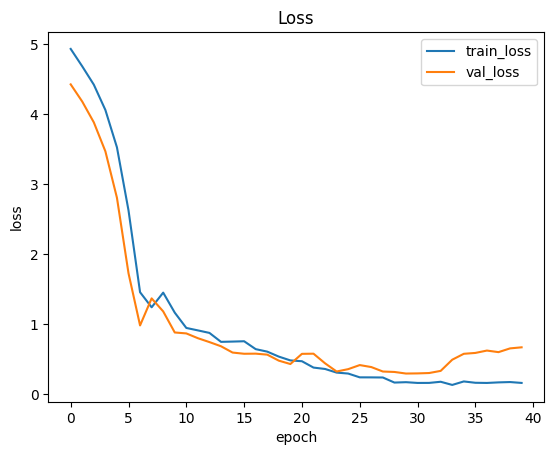

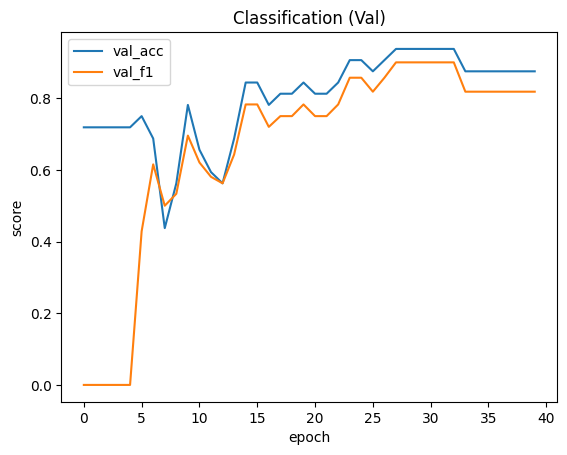

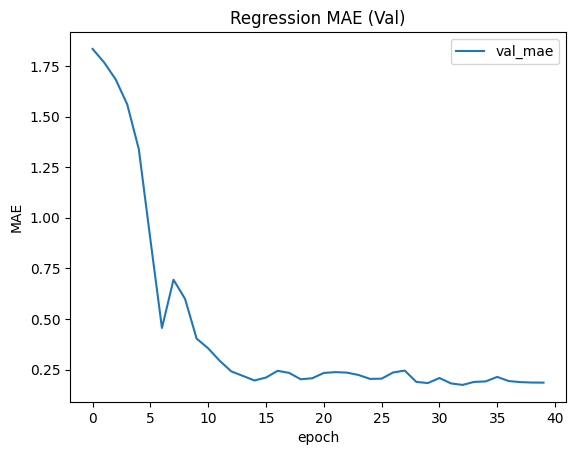

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist["train_loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

plt.figure()
plt.plot(hist["val_acc"], label="val_acc")
plt.plot(hist["val_f1"], label="val_f1")
plt.legend(); plt.title("Classification (Val)"); plt.xlabel("epoch"); plt.ylabel("score"); plt.show()

plt.figure()
plt.plot(hist["val_mae"], label="val_mae")
plt.legend(); plt.title("Regression MAE (Val)"); plt.xlabel("epoch"); plt.ylabel("MAE"); plt.show()

## 9) Final Test Metrics + Confusion Matrix

In [ ]:
import json, numpy as np

def to_py(x):
    if isinstance(x, (np.floating, np.integer)):
        return x.item()
    return x

test_scores_py = {k: to_py(v) for k, v in test_scores.items()}
print("TEST:", json.dumps(test_scores_py, indent=2))


TEST: {
  "loss": 0.2664611577987671,
  "acc": 0.95,
  "prec": 1.0,
  "rec": 0.9,
  "f1": 0.9473684210526315,
  "roc": 0.9775,
  "prauc": 0.9832142857142856,
  "mae": 0.2112843096256256,
  "rmse": 0.26786949833121204,
  "r2": 0.8193901181221008
}
